In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from ellipse import LsqEllipse
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from skimage import io
import matplotlib.pyplot as plt
import math
import pickle
import statistics
from statistics import mean
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks


from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

In [2]:
import speckle
from speckle.inference.read_in_data import *
from speckle.inference.correlation_heatmap import *
from speckle.inference.calculating_tau import *
from speckle.inference.dedrift import *

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import DSH
import matplotlib.pyplot as plt

In [4]:
video_time_length=120 #s
video_frame_numbers=6010 #frames
imgname='28p_1wt_100nm128px_2min_glycerol_1au_20x_26p5umhigh_405nm_20xobjective'
foldername='/Volumes/WENYUN WANG/Colloidal analysis/28p_1wt_100nm128px_2min_glycerol_1au_20x_26p5umhigh_405nm_20xobjective/'
framespeed=video_time_length/video_frame_numbers

In [5]:
# read the image stack
img = io.imread(foldername+imgname+'.tif')
frame_number=img.shape[0]
img_height=img.shape[1]
img_width=img.shape[2]

In [6]:
img.shape

(6010, 128, 128)

# Speckle size

speckle size is 1.8257418583505538 pixel, 0.3025757140123556 um

# Intensity averaging over neighboring pixels

In [7]:
# create matrix:
w=2
h=2
omega=w*h
matrix=np.zeros((w,h))
for i in range(0,w):
    for j in range(0,h):
        matrix[i][j]=1/omega

In [8]:
def compute_intensity(px, matrix, img):
    intensity=[]
    for t in range(0,img.shape[0],1):
        kerneled_intensity=0
        start_y=px[0]-math.floor(matrix.shape[0]/2)
        start_x=px[1]-math.floor(matrix.shape[1]/2)
        for y_i in range(0,matrix.shape[1],1):
            for x_i in range(0,matrix.shape[1],1):
                y_pixel=start_y+y_i
                x_pixel=start_x+x_i
                kerneled_intensity=kerneled_intensity+matrix[y_i,x_i]*img[t][y_pixel,x_pixel]
        intensity_t=kerneled_intensity
        intensity.append(intensity_t)

    plt.figure(figsize=(8,5))
    #plt.ylim([0, 255])
    plt.plot(range(0,img.shape[0],1),intensity,'-')
    plt.legend(['Intensity vs Time'], fontsize=18)
    plt.xlabel("Time [s]",fontsize=18)
    plt.ylabel("Intensity",fontsize=18)
    
    return intensity

In [9]:
def compute_g2t(px,laglist_g2t, matrix):
    intensity=compute_intensity(px, matrix, img)
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=img.shape[0]-lag
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    return g2t, intensity

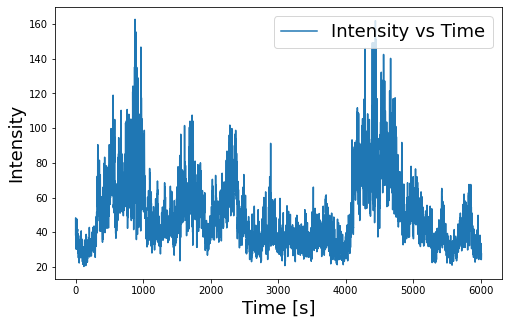

In [13]:
laglist_g2t=range(0,500,1)
px=[43,66] #[y,x]
g2t,intensity=compute_g2t(px,laglist_g2t,matrix)

Text(0, 0.5, 'g2(t)')

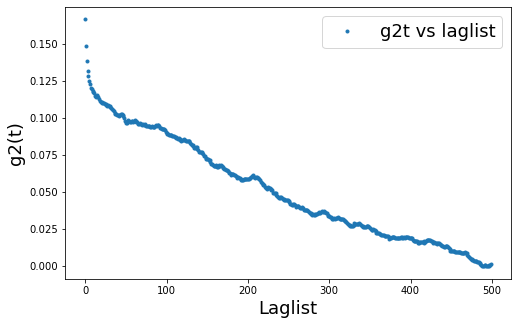

In [14]:
plt.figure(figsize=(8,5))
plt.plot(laglist_g2t,g2t,'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Laglist",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)

Text(0, 0.5, 'g2(t)')

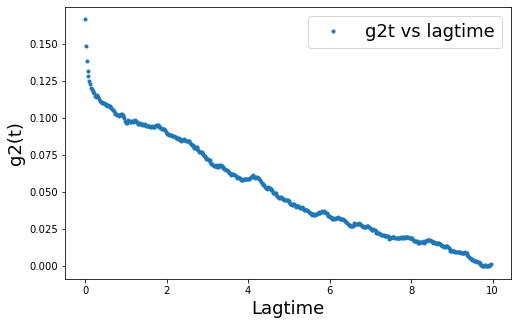

In [15]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]

plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t,g2t,'.')
plt.legend(['g2t vs lagtime'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)

# Correlation averaging over all pixels

In [9]:
def compute_g2t_wo_kernel(px,laglist_g2t):
    intensity=[]
    for t in range(0,img.shape[0],1):
        intensity.append(img[t][px[0],px[1]])
        
    g2t=[]
    for lag in laglist_g2t:
        numerator_sum=0
        denumerator_sum_1=0
        denumerator_sum_2=0
        max_t_range=img.shape[0]-lag
        for t in range(0,max_t_range,1):
            numerator_sum=numerator_sum+int(intensity[t])*int(intensity[t+lag])
            denumerator_sum_1=denumerator_sum_1+int(intensity[t])
            denumerator_sum_2=denumerator_sum_2+int(intensity[t+lag])
        numerator=numerator_sum/max_t_range
        denumerator_1=denumerator_sum_1/max_t_range
        denumerator_2=denumerator_sum_2/max_t_range
        g2t.append((numerator/denumerator_1/denumerator_2)-1)
    return g2t

In [26]:
laglist_g2t=range(0,500,1)
averaged_g2t=[]
for y in range(30,90,1):
    for x in range(30,90,1):
        px=[y,x]
        g2t=compute_g2t_wo_kernel(px,laglist_g2t)
        averaged_g2t.append(g2t)

In [27]:
average_g2t=np.mean(averaged_g2t,axis=0)

Text(0, 0.5, 'g2(t)')

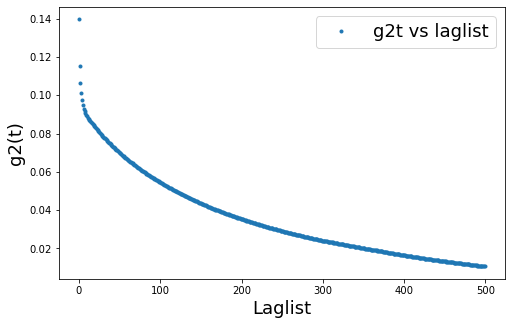

In [28]:
plt.figure(figsize=(8,5))
plt.plot(laglist_g2t,average_g2t,'.')
plt.legend(['g2t vs laglist'], fontsize=18)
plt.xlabel("Laglist",fontsize=18)
plt.ylabel("g2(t)",fontsize=18)

# Fitting tau

tau is: 0.23404153364565008
y = -4.27275 * x + -2.02746


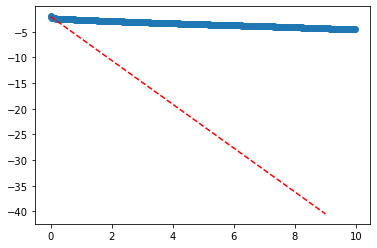

In [62]:
lagtime_g2t= [element * framespeed for element in laglist_g2t]
plateau=0 # np.mean(average_g2t[-200:-1])
tau, a, b=fit_exponential_decay(plateau,np.array(average_g2t),lagtime_g2t,0,5, True)

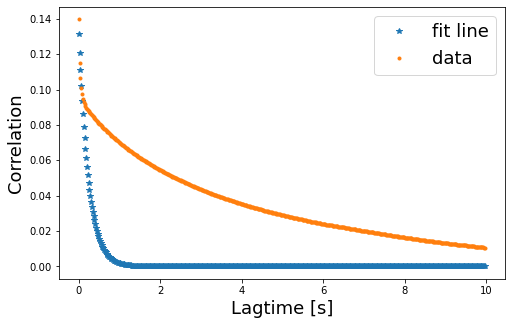

In [63]:
reconstruct(lagtime_g2t,plateau,np.array(average_g2t),a,b)

In [64]:
# calculate q
angle=180
lamda=405 #nm
k=2*math.pi/lamda
q=2*k*math.sin(math.radians(angle/2))*10**(9)

In [65]:
D=a/(-2*q**2)
print(D)

2.2190515300930408e-15


# Expected g2t:
We know $D=\frac{kt}{6\pi\eta r}$, $g2t=\exp(-2Dq^2dt)$

In [118]:
kb=1.380649*10**(-23) # J*K^(-1)
T=270 # K
eta=1.412 # Pa*S
r=50*10**(-9) # m
D=kb*T/(6*math.pi*eta*r) #m^2/s
print(D) #m^2/s

2.801181327512663e-15


In [109]:
lagtime_g2t=np.array(lagtime_g2t)
g2t_expected=np.exp(-2*D*(q**2)*lagtime_g2t)

Text(0, 0.5, 'g2(t) expected')

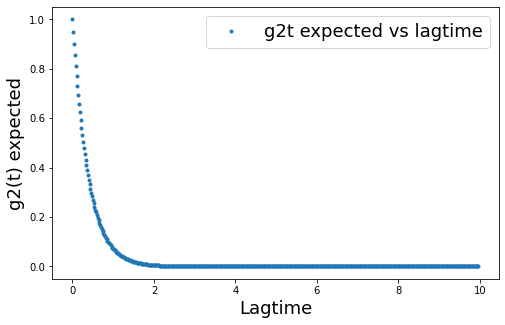

In [110]:
plt.figure(figsize=(8,5))
plt.plot(lagtime_g2t,g2t_expected,'.')
plt.legend(['g2t expected vs lagtime'], fontsize=18)
plt.xlabel("Lagtime",fontsize=18)
plt.ylabel("g2(t) expected",fontsize=18)